## Time Series to tabular form

Models used are:<br>
Decision Tree<br>
Random Forest<br>
Linear Model<br>
Support Vector Machine<br>

In [3]:
import os
import datetime
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from sklearn.preprocessing import MinMaxScaler
import warnings
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import plotly.io as pio
import cufflinks as cf
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as LR
from sklearn.tree import DecisionTreeRegressor as DT
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
mpl.rcParams.update({"axes.grid" : False, "grid.color": "black"})

pd.options.plotting.backend = 'plotly'

pio.templates.default = "plotly"
cf.go_offline()


In [4]:
df = pd.read_csv("bayut3.csv", thousands=',')
df = df[['beds', 'baths', 'area', 'location', 'price']].dropna(how='any')

df.beds = df.beds.str.split(' ', 1, expand=True)[0]
df.baths = df.baths.str.split(' ', 1, expand=True)[0]

area_unit =  df.area.str.split(' ', 1, expand=True)[1]
area =  df.area.str.split(' ', 1, expand=True)[0]

df['unit'] = area_unit
df.area = area.str.replace(',', '').astype(float)

c_area= []
for a, u in zip(df.area, df.unit):
    if u == 'sqft':
        c_area.append(a/10.764)
    else:
        c_area.append(a)

df.area = c_area
# df.to_csv('bayutTest2.csv')

studio_factor = 0.6
df = df.replace('Studio', studio_factor)
df.beds = df.beds.astype(float)
df.baths = df.baths.astype(float)

regions = []
for loc in df.location:
    region = loc.split(',')[-2]
    regions.append(str(region))
    
df['region'] = regions

df = df.drop(['location', 'unit'], axis=1)

In [5]:
df.region = df.region.map(lambda x: x[1:])

In [6]:
df.head()

,beds,baths,area,price,region
0,2.0,2.0,105.258268,1800000,The Lagoons
1,2.0,3.0,130.063174,1125000,Motor City
2,3.0,4.0,360.460795,3600000,Dubai Marina
4,0.6,1.0,34.838350,405000,Jumeirah Village Circle (JVC)
5,3.0,4.0,145.856559,2100000,Business Bay


In [7]:
known_categories = df.region.unique()
known_categories

array(['The Lagoons', 'Motor City', 'Dubai Marina',
       'Jumeirah Village Circle (JVC)', 'Business Bay',
       'Dubai Hills Estate', 'Serena', 'The Springs', 'Bluewaters Island',
       'Jumeirah Golf Estate', 'The Meadows', 'Palm Jumeirah',
       'The Views', 'Jumeirah Lake Towers (JLT)', 'Arabian Ranches',
       'Dubai Sports City', 'Emirates Hills', 'Arabian Ranches 2',
       'Mohammad Bin Rashid City', 'Al Warsan',
       'DAMAC Hills (Akoya by DAMAC)', 'Green Community',
       'Dubai Industrial Park', 'Jumeirah Village Triangle (JVT)',
       'Dubai Festival City', 'Dubai Silicon Oasis', 'Umm Suqeim',
       'Mudon', 'Remraam', 'Dubai Residence Complex', 'Wasl Gate',
       'Jumeirah Islands', 'Downtown Jebel Ali', 'Jumeirah',
       'Town Square', 'Old Town', 'Al Furjan', 'Dubai South', 'Dubailand',
       'Reem', 'The Greens', 'Arjan', 'Dubai World Central', 'Al Barari',
       'Jumeirah Beach Residence (JBR)', 'Discovery Gardens', 'The Lakes',
       'International City

In [8]:
df.corr(method='kendall')['price'].sort_values(ascending=False).to_frame().T

,price,area,beds,baths
price,1.0,0.720047,0.711074,0.665539


In [9]:
df.corr(method='spearman')['price'].sort_values(ascending=False).to_frame().T

,price,area,beds,baths
price,1.0,0.896362,0.85231,0.81324


In [10]:
df.corr(method='pearson')['price'].sort_values(ascending=False).to_frame().T

,price,beds,baths,area
price,1.0,0.549498,0.537223,0.454626


In [11]:
def one_hot_encoder(x):
    county_dummies = pd.get_dummies(x.region)
    df1 = pd.concat([x, county_dummies], axis=1)
    return df1.drop('region',axis=1)

df = one_hot_encoder(df)

In [12]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

# scaled_df = pd.DataFrame(scaler.fit_transform(tabular_df), columns=tabular_df.columns)

x = df.drop('price', axis=1)

scale = True

if scale:
    x = pd.DataFrame(x_scaler.fit_transform(x), columns=x.columns)
    y = pd.DataFrame(y_scaler.fit_transform(df[['price']]), columns=['price'])
else:
    x = pd.DataFrame(x, columns=x.columns)
    y = pd.DataFrame(df[['price']], columns=['price'])

shuffle = True
train_size = int(len(x)*0.8)

if shuffle:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
else:
    x_train, x_test, y_train, y_test = x[:train_size], x[train_size:], y[:train_size], y[train_size:]

lr = LR()
dt = DT()
rf = RF()
svr = SVR()

models = [lr, dt, rf, svr]
models_names = ['Linear Model', 'Decision Tree', 'Random Forest', 'SVM']

def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

metrics = ['mean_absolute_error', 'r2_score', 'mean_squared_error']

train_scores = {}
test_scores = {}
model_preds = {}

test_df = y_test.copy()
train_df = y_train.copy()

In [13]:
for model, model_name in zip(models, models_names):
    model.fit(x_train, y_train)
    
    test_df[model_name] = model.predict(x_test).flatten()
    train_df[model_name] = model.predict(x_train).flatten()

    train_scores[model_name] = []
    test_scores[model_name] = []
    
    for metric in metrics:
        train_scores[model_name].append(eval(metric)(train_df[model_name], y_train))
        test_scores[model_name].append(eval(metric)(test_df[model_name], y_test))
        
test_df.sort_index(inplace=True)
train_df.sort_index(inplace=True)

In [14]:
test_scores = pd.DataFrame(test_scores, index = metrics)
train_scores = pd.DataFrame(train_scores, index = metrics)

In [15]:
if scale:
    for c in test_df:
        test_df[c] = y_scaler.inverse_transform(test_df[[c]]).flatten()

    for c in train_df:
        train_df[c] = y_scaler.inverse_transform(train_df[[c]]).flatten()

In [16]:
train_scores

,Linear Model,Decision Tree,Random Forest,SVM
mean_absolute_error,0.016144,0.000590,0.002440,0.058419
r2_score,0.070762,0.997176,0.973667,-0.747678
mean_squared_error,0.001497,0.000009,0.000074,0.004239


In [17]:
test_scores

,Linear Model,Decision Tree,Random Forest,SVM
mean_absolute_error,0.015938,0.006795,0.005935,0.058943
r2_score,0.207966,0.507360,0.598939,-0.803636
mean_squared_error,0.001332,0.001070,0.000765,0.004447


In [18]:
pct_error = test_df.copy()
for c in pct_error:
    pct_error[f'{c}_error'] = round(abs(pct_error[c] - pct_error['price'])/pct_error['price'] * 100, 2)
pct_error.drop('price_error', axis=1, inplace=True)

In [19]:
pct_error

,price,Linear Model,Decision Tree,Random Forest,SVM,Linear Model_error,Decision Tree_error,Random Forest_error,SVM_error
1,1125000.0,8.915574e+05,1.140000e+06,1.201040e+06,7.818284e+06,20.75,1.33,6.76,594.96
5,9690888.0,9.590045e+06,9.682888e+06,9.674801e+06,1.099622e+07,1.04,0.08,0.17,13.47
12,1875000.0,2.470654e+06,2.200000e+06,2.101403e+06,9.129954e+06,31.77,17.33,12.07,386.93
21,54000000.0,3.298041e+07,3.300000e+07,2.998250e+07,2.502850e+07,38.93,38.89,44.48,53.65
22,1700000.0,2.113264e+06,1.650000e+06,1.578290e+06,6.701058e+06,24.31,2.94,7.16,294.18
...,...,...,...,...,...,...,...,...,...
11720,3200000.0,4.009375e+06,3.194000e+06,3.187441e+06,9.163148e+06,25.29,0.19,0.39,186.35
11735,1784888.0,2.605236e+06,1.550262e+06,1.543915e+06,1.110673e+07,45.96,13.15,13.50,522.26
11739,790000.0,-8.624956e+05,7.960000e+05,8.173052e+05,5.275772e+06,209.18,0.76,3.46,567.82
11741,710888.0,1.643722e+06,7.021660e+05,7.041950e+05,3.114156e+05,131.22,1.23,0.94,56.19


In [20]:
pct_error.mean().iloc[-4:]

Linear Model_error      127.589486
Decision Tree_error      62.671339
Random Forest_error      60.690281
SVM_error              1511.303733
dtype: float64

In [21]:
forest_error = pct_error['Random Forest_error']
forest_error = pd.cut(forest_error, range(0, int(forest_error.max()+2), 10), right=True, ).value_counts()

In [22]:
pct_error[['Random Forest_error']][:].plot()

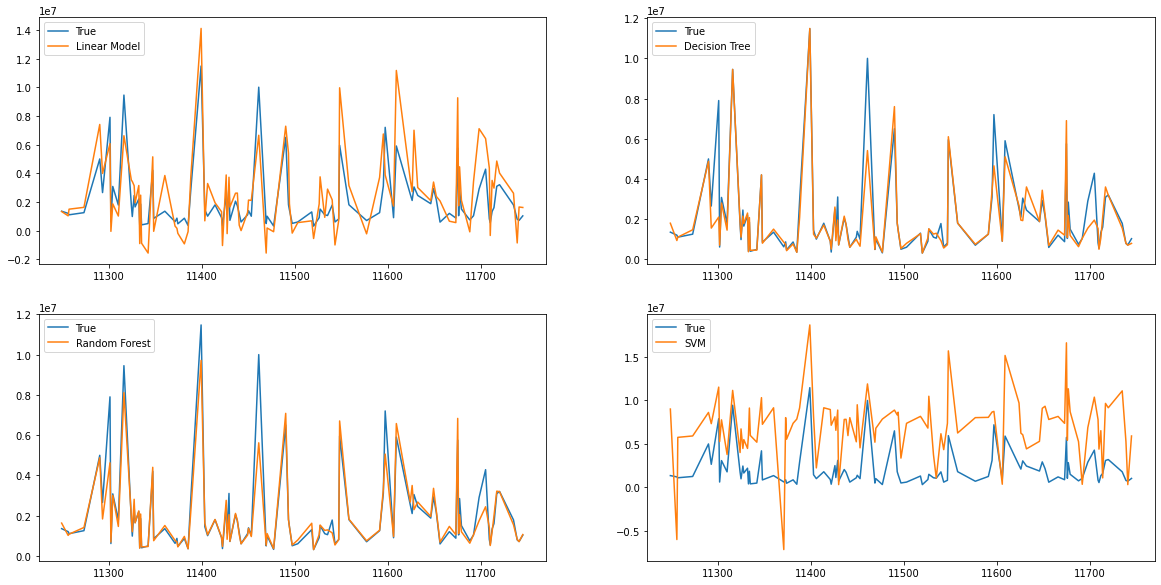

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(20,10))
axs = axs.flatten()

for i, ax in zip(models_names, axs):
    ax.plot(test_df['price'][-100:], label='True')
    ax.plot(test_df[i][-100:], label=i)
    ax.legend(loc='upper left')

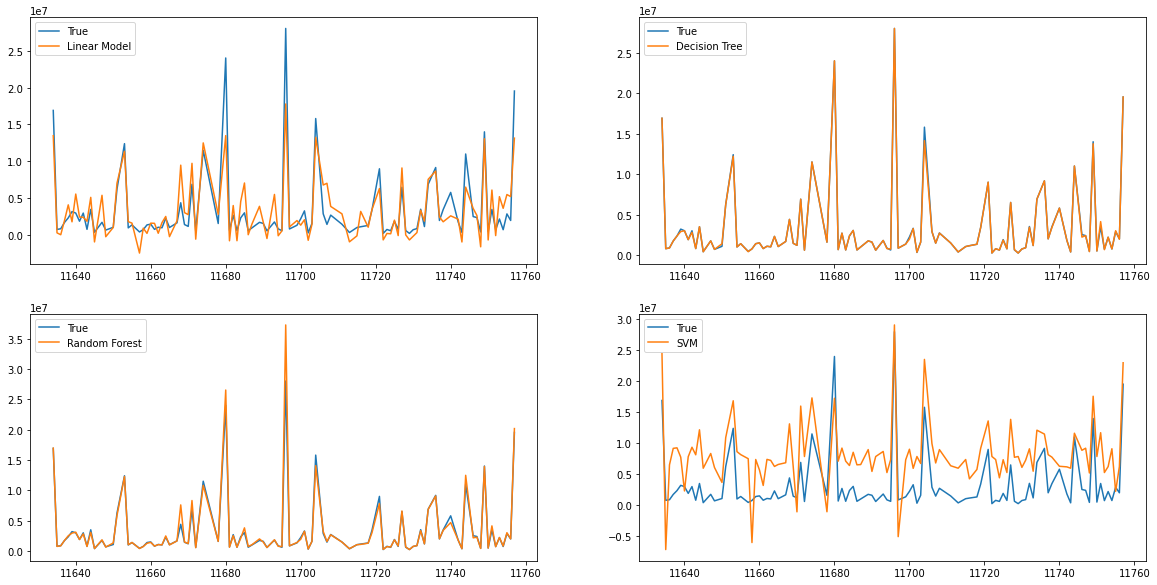

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(20,10))
axs = axs.flatten()

for i, ax in zip(models_names, axs):
    ax.plot(train_df['price'][-100:], label='True')
    ax.plot(train_df[i][-100:], label=i)
    ax.legend(loc='upper left')

In [25]:
(test_df['Random Forest'] -test_df['price']).plot()

In [26]:
known_categories = ['The Lagoons', 'Motor City', 'Dubai Marina',
       'Jumeirah Village Circle (JVC)', 'Business Bay',
       'Dubai Hills Estate', 'Serena', 'The Springs', 'Bluewaters Island',
       'Jumeirah Golf Estate', 'The Meadows', 'Palm Jumeirah',
       'The Views', 'Jumeirah Lake Towers (JLT)', 'Arabian Ranches',
       'Dubai Sports City', 'Emirates Hills', 'Arabian Ranches 2',
       'Mohammad Bin Rashid City', 'Al Warsan',
       'DAMAC Hills (Akoya by DAMAC)', 'Green Community',
       'Dubai Industrial Park', 'Jumeirah Village Triangle (JVT)',
       'Dubai Festival City', 'Dubai Silicon Oasis', 'Umm Suqeim',
       'Mudon', 'Remraam', 'Dubai Residence Complex', 'Wasl Gate',
       'Jumeirah Islands', 'Downtown Jebel Ali', 'Jumeirah',
       'Town Square', 'Old Town', 'Al Furjan', 'Dubai South', 'Dubailand',
       'Reem', 'The Greens', 'Arjan', 'Dubai World Central', 'Al Barari',
       'Jumeirah Beach Residence (JBR)', 'Discovery Gardens', 'The Lakes',
       'International City', 'The Hills', 'Liwan', 'Mina Rashid', 'DIFC',
       'Culture Village', 'Barsha Heights (Tecom)', 'Arabian Ranches 3',
       'Akoya Oxygen', 'Al Quoz', 'Mirdif', 'Jumeirah Heights',
       'Jumeirah Park', 'Dubai Production City (IMPZ)', 'The Villa',
       'Dubai Science Park', 'Bur Dubai', 'Meydan City', 'Nad Al Sheba',
       'Dubai Studio City', 'Pearl Jumeirah',
       'Dubai Investment Park (DIP)', 'Dubai Harbour', 'Al Sufouh',
       'Dragon City', 'Jebel Ali', 'Al Barsha', 'The World Islands',
       'World Trade Centre']

location = pd.Categorical(['Dubai Harbour'], categories = known_categories)
location_dummy = pd.get_dummies(location).values.flatten().tolist()

In [27]:
test = np.array([3, 3, 200] + location_dummy).reshape(1, -1)
pipe = Pipeline([('scaler', x_scaler), ('forest', rf)])
int(y_scaler.inverse_transform(pipe.predict(test).reshape(-1, 1)))

2382758

In [28]:
to_save = {'pipe':pipe, 'y_scaler':y_scaler, 'regions':known_categories}
import pickle
f = open('inference.pickle', 'wb')
pickle.dump(to_save, f)

In [8]:
import pickle
import pandas as pd
import numpy as np

    
f = open('inference.pickle', 'rb')
dict_ = pickle.load(f)

def inference(beds, baths, area, location):


    location = pd.Categorical([location], categories = dict_['regions'])
    location_dummy = pd.get_dummies(location).values.flatten().tolist()

    test = np.array([beds, baths, area] + location_dummy).reshape(1, -1)

    pipe = dict_['pipe']
    price = int(dict_['y_scaler'].inverse_transform(pipe.predict(test).reshape(-1, 1)))

    return price

In [18]:
beds = 7
baths = 1
area = 50
location = 'Dubai Harbour'

inference(beds, baths, area, location)

591019